# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


### Change directory

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load the training data from train.csv file

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

DATASET_FOLDER = "/content/drive/My Drive/Advance Computer Vision/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
#VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

images_zip_path = DATASET_FOLDER + "images_racoon.rar"

from zipfile import ZipFile

In [0]:
TRAIN_CSV

'/content/drive/My Drive/Advance Computer Vision/train_labels.csv'

In [0]:
!pip install patool

In [0]:
images_rar='/content/drive/My Drive/Advance Computer Vision/images_racoon.rar'
import patoolib
patoolib.extract_archive('/content/drive/My Drive/Advance Computer Vision/images_racoon.rar', outdir='/content/drive/My Drive/Advance Computer Vision/')

patool: Extracting /content/drive/My Drive/Advance Computer Vision/images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Advance Computer Vision/images_racoon.rar"
patool:     with cwd='/content/drive/My Drive/Advance Computer Vision/'


PatoolError: ignored

### Print the shape of the train dataset

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    #returns the number of rows in csv file
    print(csvfile)
    coords = np.zeros((sum(1 for line in csvfile), 4))
    coords=coords[:-1]
    #print(coords)
    #4 represents x0my0,x1,y1
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
      #print(row)
      #for i, r in enumerate(row[0:8]):
      if(row[1]!='width'):
        fname=row[0]
        image_height=int(row[1])
        image_width=int(row[2])
        x0=int(row[4])
        y0=int(row[5])
        x1=int(row[6])
        y1=int(row[7])
        path = '/content/drive/My Drive/Advance Computer Vision/images/'+fname
        coords[col-1, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col-1, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
          #width
        coords[col-1, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
          #height
        coords[col-1, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

<_io.TextIOWrapper name='/content/drive/My Drive/Advance Computer Vision/train_labels.csv' mode='r' encoding='UTF-8'>


In [0]:
batch_images.shape

(173, 128, 128, 3)

In [0]:
len(paths)

173

In [0]:
print(len(coords))

173


'/content/drive/My Drive/Advance Computer Vision/images_racoon.rar'

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
# Done in the previous step

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
# Done in the previous step

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
# Done in the previous step

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)












17227776/17225924 [==============================] - 1s 0us/step


image


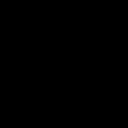

In [0]:
import os
import cv2
from google.colab.patches import cv2_imshow
#img = cv2.imread(os.path.join('/content/drive/My Drive/Advance Computer Vision/Hands/', 'frame_2451.jpg'))
img = batch_images[100]
print('image')
#cv2.rectangle(img, (821,524), (1104,719), (0, 224, 0), 2) #821,524,1104,719
#cv2.rectangle(img, (647, 453), (825, 552), (0, 224, 0), 2)
cv2_imshow(img)
if cv2.waitKey(0) == 27:
  sys.exit()

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt=coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Epoch 1/30
173/173 [==============================] - 7s 41ms/step - loss: 3298.1047 - IoU: 0.0722
Epoch 2/30
173/173 [==============================] - 0s 739us/step - loss: 1013.1984 - IoU: 0.3704
Epoch 3/30
173/173 [==============================] - 0s 737us/step - loss: 942.8382 - IoU: 0.4187
Epoch 4/30
173/173 [======

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/Advance Computer Vision/Raccoon-Test.jpg'
unscaled = cv2.imread(filename) # Original image for display

In [0]:
unscaled.shape

(183, 275, 3)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))


AttributeError: ignored

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [0]:
image


NameError: ignored

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

SyntaxError: ignored

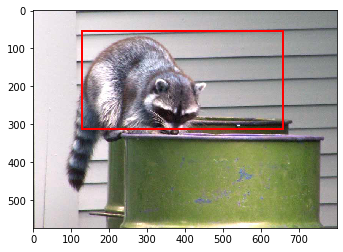

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Change your present working directory

In [3]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [4]:
import os 
  
# Get the path of current working directory 
path = os.getcwd() 
path

'/content'

In [0]:
project_path = "/content/drive/My Drive/Advance Computer Vision/"
os.chdir(project_path)

In [6]:
path = os.getcwd() 
path

'/content/drive/My Drive/Advance Computer Vision'

### Load your data file

In [0]:
import pandas as pd
import numpy as np


missing_values = ["n/a", "na", "--", "?" ]

tdata = pd.read_csv('daily-minimum-temperatures-in-me.csv',na_values = missing_values)

In [8]:
tdata.sample(n=10)

,Date,Temperature
660,1982-10-23,10.6
3533,1990-09-06,10.3
2315,1987-05-06,11.8
749,1983-01-20,11.6
856,1983-05-07,11.6
140,1981-05-21,3.4
3611,1990-11-23,10.5
494,1982-05-10,7.6
1633,1985-06-23,0.6
3189,1989-09-27,9.0


#### Plot data

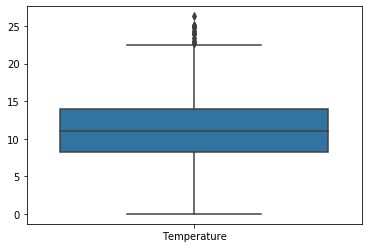

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#Create a boxplot
sns.boxplot(data=tdata)  

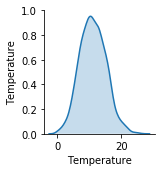

In [10]:
import seaborn as sns
import matplotlib as plt
%matplotlib inline
sns.pairplot(tdata, diag_kind='kde')

#### Descibe your dataframe

In [11]:
tdata.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [12]:
tdata.isna().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [0]:
data = tdata.dropna()

In [16]:
data.shape

(3650, 2)

#### Get the representation of the distribution of data in the form of histogram

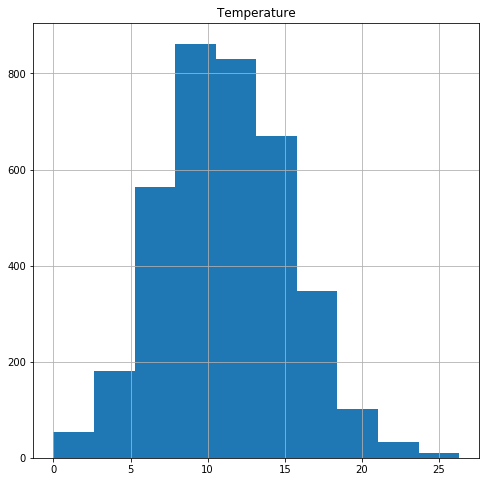

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (8,8))
ax = fig.gca()
data.hist(ax=ax)
plt.show()

#### Check the maximum and minimum values

In [15]:
print(tdata.max()) 

print(np.max(tdata)) 

print(tdata.min()) 

print(np.min(tdata)) 

Date           1990-12-31
Temperature          26.3
dtype: object
Date           1990-12-31
Temperature          26.3
dtype: object
Date           1981-01-01
Temperature             0
dtype: object
Date           1981-01-01
Temperature             0
dtype: object


### Normalize the data

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(tdata[['Temperature']])
scaled

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

#### Check the maximum and minimum values of scaled data

In [17]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [21]:
scaled

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]


#### Print train and test size

In [19]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataset[i + look_back]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [21]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
1095 1


In [31]:
X_train

array([[[0.78707224]],

       [[0.68060837]],

       [[0.7148289 ]],

       ...,

       [[0.61596958]],

       [[0.53992395]],

       [[0.54372624]]])

In [1]:
y_train.shape

NameError: ignored

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [23]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

### Summarize your model

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=2, shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





 - 21s - loss: 0.0175
Epoch 2/30
 - 11s - loss: 0.0132
Epoch 3/30
 - 11s - loss: 0.0124
Epoch 4/30
 - 11s - loss: 0.0123
Epoch 5/30
 - 12s - loss: 0.0118
Epoch 6/30
 - 11s - loss: 0.0113
Epoch 7/30
 - 11s - loss: 0.0107
Epoch 8/30
 - 11s - loss: 0.0107
Epoch 9/30
 - 11s - loss: 0.0106
Epoch 10/30
 - 11s - loss: 0.0104
Epoch 11/30
 - 11s - loss: 0.0103
Epoch 12/30
 - 11s - loss: 0.0103
Epoch 13/30
 - 11s - loss: 0.0102
Epoch 14/30
 - 11s - loss: 0.0103
Epoch 15/30
 - 11s - loss: 0.0102
Epoch 16/30
 - 11s - loss: 0.0102
Epoch 17/30
 - 11s - loss: 0.0103
Epoch 18/30
 - 11s - loss: 0.0102
Epoch 19/30
 - 11s - loss: 0.0102
Epoch 20/30
 - 11s - loss: 0.0102
Epoch 21/30
 - 11s - loss: 0.0103
Epoch 22/30
 - 11s - loss: 0.0101
Epoch 23/30
 - 11s - loss: 0.0102
Epoch 24/30
 - 11s - loss: 0.0102
Epoch 25/30
 - 11s - loss: 0.0102
Epoch 26/30
 - 10s - loss: 0.0102
Epoch 27/30
 - 11s - l

## Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test, batch_size=batch_size)
model.reset_states()

In [27]:
scaler.inverse_transform(y_train)

array([[17.9],
       [18.8],
       [14.6],
       ...,
       [14.2],
       [14.3],
       [13.3]])

In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

In [29]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.67 RMSE
Test Score: 2.57 RMSE


## Plot the results

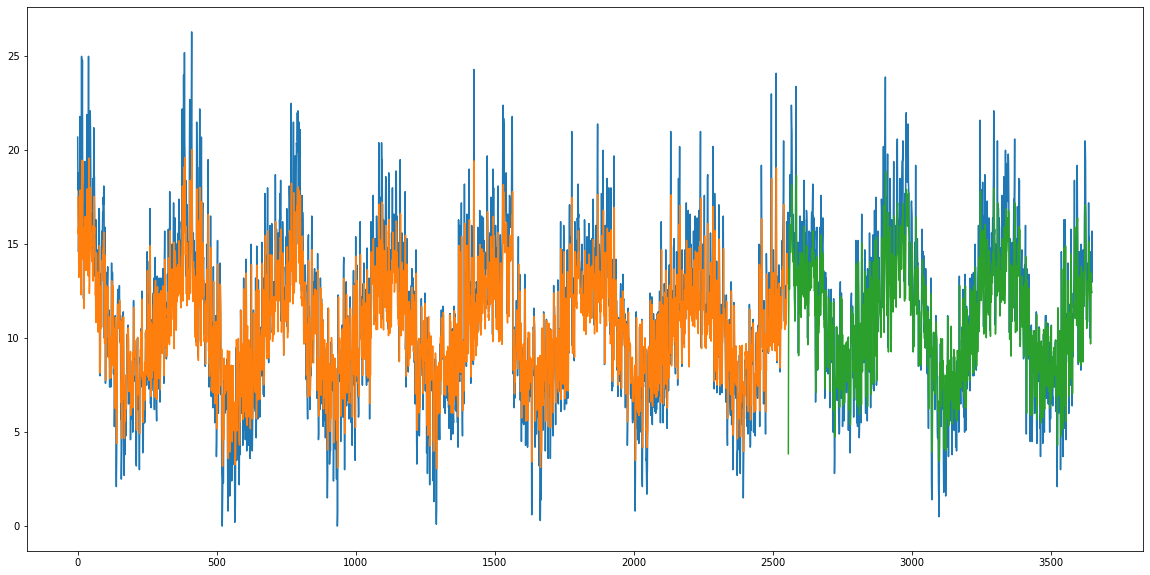

In [30]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()